# Fine Tune

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

import torch
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset

import tqdm as tqdm

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare Dataset

In [11]:
mbti_df = pd.read_csv('../processed/all_data_3.csv')

In [12]:
mbti_df

,Unnamed: 0,type,tweet
0,0,ISFJ,"Mindhunter, Broadchurch, The Sinner, Orphan Bl..."
1,1,ISFJ,Tinder has your health in mind.
2,2,ISFJ,5 of 5 stars to Pretty Face by Lucy Parker
3,3,ISFJ,Outstanding faculty from and more at Winter Co...
4,4,ISFJ,"Using pray and wait on God, can be a means of ..."
...,...,...,...
106322,106322,ESTP,This is so legit holy shit lol I work in rando...
106323,106323,ESTP,Same here When Im in a group Im fairly quiet u...
106324,106324,ESTJ,Im more worried about the idea that we are sla...
106325,106325,ESTP,Believing you dont have ethics is still an eth...


### Add column `introvert_extrovert`

In [13]:
mbti_df['introvert_extrovert'] = mbti_df['type'].apply(lambda x: 'Introvert' if x[0] == 'I' else 'Extrovert')

In [14]:
mbti_df.sample(10)

,Unnamed: 0,type,tweet,introvert_extrovert
81841,81841,ISTP,for the most part i love it i like feeling use...,Introvert
13340,13340,ENFP,Really With those lines Oh hell no I dont thin...,Extrovert
2355,2355,ENFJ,How are your energy levels By which I mean do ...,Extrovert
11689,11689,ENFP,I love the fall weather in a way its comfortin...,Extrovert
19850,19850,ENTJ,i guess i should have explained my point your ...,Extrovert
20830,20830,ENTJ,lordmercurio im sorry but i think you misunder...,Extrovert
4594,4594,ENFJ,not really i like the shy ones and if anything...,Extrovert
12204,12204,ENFP,dont stress so much get yourself to a place wh...,Extrovert
31705,31705,ENTP,yes that is it it seems really a good choice t...,Extrovert
47546,47546,INFP,i didnt like children until i had one i suppos...,Introvert


### Consider only posts with length < 32 words

In [15]:
mbti_df = mbti_df[mbti_df['tweet'].str.split().str.len() < 32]

In [16]:
mbti_df

,Unnamed: 0,type,tweet,introvert_extrovert
0,0,ISFJ,"Mindhunter, Broadchurch, The Sinner, Orphan Bl...",Introvert
1,1,ISFJ,Tinder has your health in mind.,Introvert
2,2,ISFJ,5 of 5 stars to Pretty Face by Lucy Parker,Introvert
3,3,ISFJ,Outstanding faculty from and more at Winter Co...,Introvert
4,4,ISFJ,"Using pray and wait on God, can be a means of ...",Introvert
...,...,...,...,...
106313,106313,ESTP,True I do end up the mentor but I feel like Yo...,Extrovert
106321,106321,ESFP,LOL and thats why I got sort of mad because th...,Extrovert
106322,106322,ESTP,This is so legit holy shit lol I work in rando...,Extrovert
106324,106324,ESTJ,Im more worried about the idea that we are sla...,Extrovert


In [17]:
mbti_df = mbti_df.drop(columns=['Unnamed: 0'])

In [18]:
mbti_df.sample(10)

,type,tweet,introvert_extrovert
28707,ENTP,Everywhere because our interests are so divers...,Extrovert
26793,ENTP,King of the geeks I would talk with everyone b...,Extrovert
69297,ISFP,thank you i do want to be social but in social...,Introvert
13880,ENFP,Maybe one day Stuck in Australia for the momen...,Extrovert
46390,INFP,I dont get how you can ignore Ni when its your...,Introvert
80878,ISTP,my college experience in a nutshell freshman y...,Introvert
88769,ISTP,I would guess that they exist but I have yet t...,Introvert
86587,ISTP,first rule of the internet i learnt keep your ...,Introvert
42429,INFP,i was going to write some long contemplative r...,Introvert
89892,ESTP,i suppose when people have impairments in some...,Extrovert


C:\Users\fizuf\AppData\Local\Temp\ipykernel_27396\3209175506.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mbti_df_grouped, x='introvert_extrovert', y='n_posts', palette='husl')


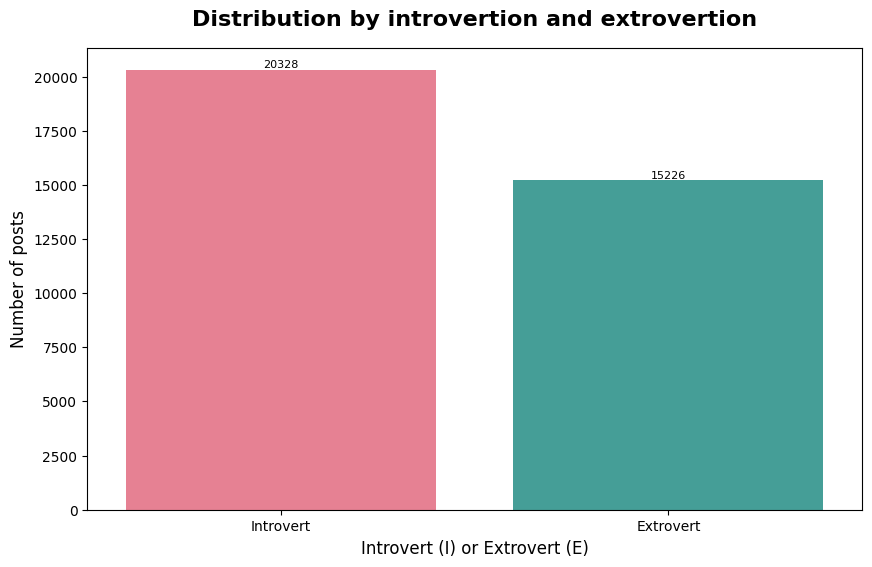

In [23]:
mbti_df_grouped = mbti_df.groupby('introvert_extrovert').size().reset_index(name='n_posts')
mbti_df_grouped = mbti_df_grouped.sort_values(by='n_posts', ascending=False)
mbti_df_grouped.columns = ['introvert_extrovert', 'n_posts']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mbti_df_grouped, x='introvert_extrovert', y='n_posts', palette='husl')

# Add annotations (number of users above each bar)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=8, color='black')

plt.title('Distribution by introvertion and extrovertion', fontsize=16, fontweight='bold', pad=16)
plt.xlabel('Introvert (I) or Extrovert (E)', fontsize=12)
plt.ylabel('Number of posts', fontsize=12)

plt.show()

In [24]:
mbti_labels_dict = {
    'Introvert': 0,
    'Extrovert': 1,
}

### Split datasets

In [25]:
X = mbti_df['tweet']
y = mbti_df['introvert_extrovert']

y = y.map(mbti_labels_dict)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


### Fine Tune BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  
model.config.hidden_dropout_prob = 0.3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
inputs = tokenizer(X.tolist(), padding=True, truncation=True, max_length=32, return_tensors='pt')
labels = torch.tensor(y.values) 

train_dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [30]:
import joblib

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10

losses = []
acc = []
prec = []
recalls = []
f1score = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Calculate loss
        loss = criterion(logits, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        
        # Track predictions and labels
        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / len(train_dataloader)

    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")
    
    # Calculate metrics (accuracy, precision, recall, F1-score)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    acc.append(accuracy)
    prec.append(precision)
    recalls.append(recall)
    f1score.append(f1)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


joblib.dump(model, 'data/model_3.joblib')
joblib.dump(tokenizer, 'data/tokenizer_3.joblib')

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Loss: 0.6794853951102051
Accuracy: 0.5733, Precision: 0.5487, Recall: 0.5733, F1-Score: 0.5020
Epoch 2/10, Loss: 0.6523785028405545
Accuracy: 0.6130, Precision: 0.6046, Recall: 0.6130, F1-Score: 0.5970
Epoch 3/10, Loss: 0.5516601334539049
Accuracy: 0.7170, Precision: 0.7154, Recall: 0.7170, F1-Score: 0.7157
Epoch 4/10, Loss: 0.3578805566303298
Accuracy: 0.8451, Precision: 0.8448, Recall: 0.8451, F1-Score: 0.8449
Epoch 5/10, Loss: 0.19581714185711313
Accuracy: 0.9235, Precision: 0.9235, Recall: 0.9235, F1-Score: 0.9235
Epoch 6/10, Loss: 0.11730857793263287
Accuracy: 0.9564, Precision: 0.9564, Recall: 0.9564, F1-Score: 0.9564
Epoch 7/10, Loss: 0.08205806897895693
Accuracy: 0.9698, Precision: 0.9698, Recall: 0.9698, F1-Score: 0.9698
Epoch 8/10, Loss: 0.06494690493911273
Accuracy: 0.9760, Precision: 0.9760, Recall: 0.9760, F1-Score: 0.9760
Epoch 9/10, Loss: 0.05007106474909577
Accuracy: 0.9820, Precision: 0.9820, Recall: 0.9820, F1-Score: 0.9820
Epoch 10/10, Loss: 0.04672677954

In [31]:
import joblib

joblib.dump(model, 'data/model_3.joblib')
joblib.dump(tokenizer, 'data/tokenizer_3.joblib')

['data/tokenizer_3.joblib']

### Loss

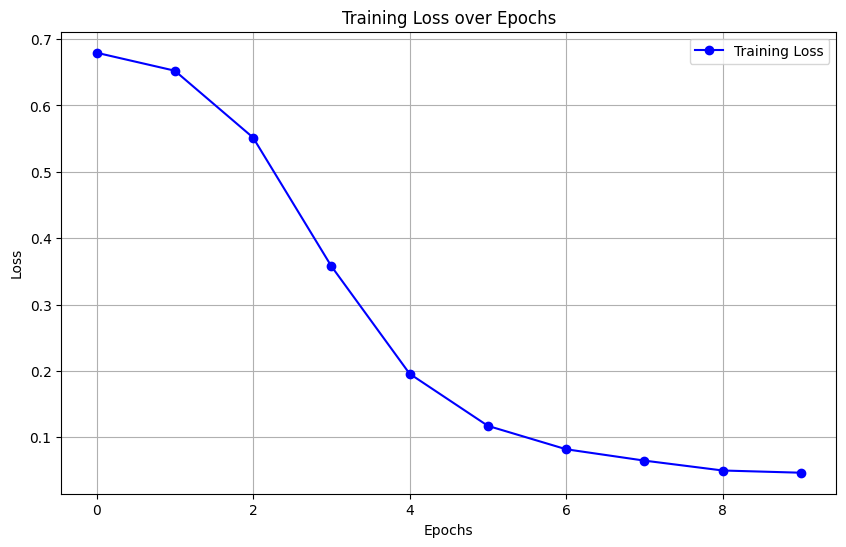

In [32]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(losses, label='Training Loss', color='b', marker='o')  # Plot losses
plt.title('Training Loss over Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show gridlines for better readability
plt.show()  # Display the plot

### Accuracy, precision, recall, and f1-score

In [33]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(all_preds, all_labels))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14246
           1       0.98      0.98      0.98     10641

    accuracy                           0.98     24887
   macro avg       0.98      0.98      0.98     24887
weighted avg       0.98      0.98      0.98     24887



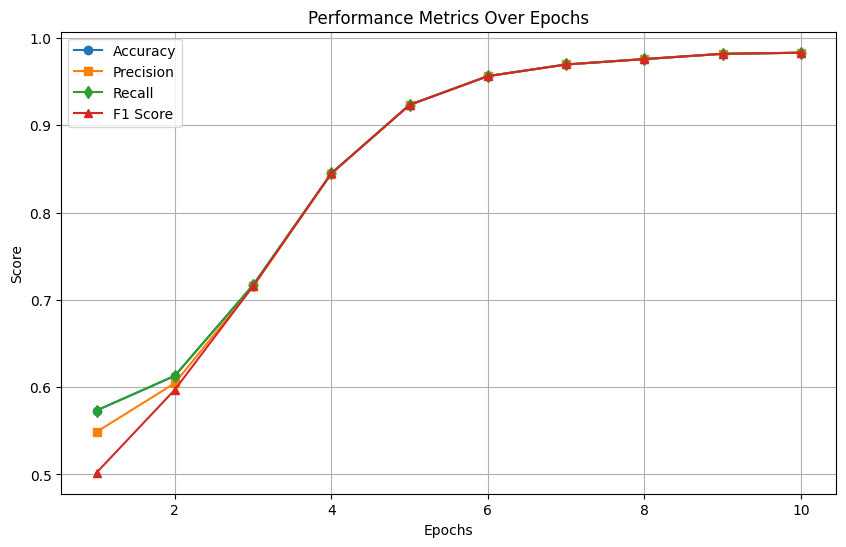

In [34]:
epochs = range(1, len(acc) + 1)

# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Accuracy', marker='o')
plt.plot(epochs, prec, label='Precision', marker='s')
plt.plot(epochs, recalls, label='Recall', marker='d')
plt.plot(epochs, f1score, label='F1 Score', marker='^')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Performance Metrics Over Epochs')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## Evaluation

In [2]:
import joblib 

model = joblib.load('data/model_2.joblib')
tokenizer = joblib.load('data/tokenizer_2.joblib')

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
import torch

model.eval()  # Set model to evaluation mode

val_preds = []
val_labels = []
all_attentions = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions
        all_attentions.append(attentions)
        logits = outputs.logits
        preds = logits.argmax(dim=-1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
                        
    # Validation metrics
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')

    print(f"Testing - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}")

# Print classification report using val_preds and val_labels
print(classification_report(val_labels, val_preds))


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Testing - Accuracy: 0.5652, Precision: 0.5581, Recall: 0.5652, F1-Score: 0.5593
              precision    recall  f1-score   support

           0       0.61      0.67      0.64      6073
           1       0.49      0.42      0.45      4594

    accuracy                           0.57     10667
   macro avg       0.55      0.55      0.55     10667
weighted avg       0.56      0.57      0.56     10667



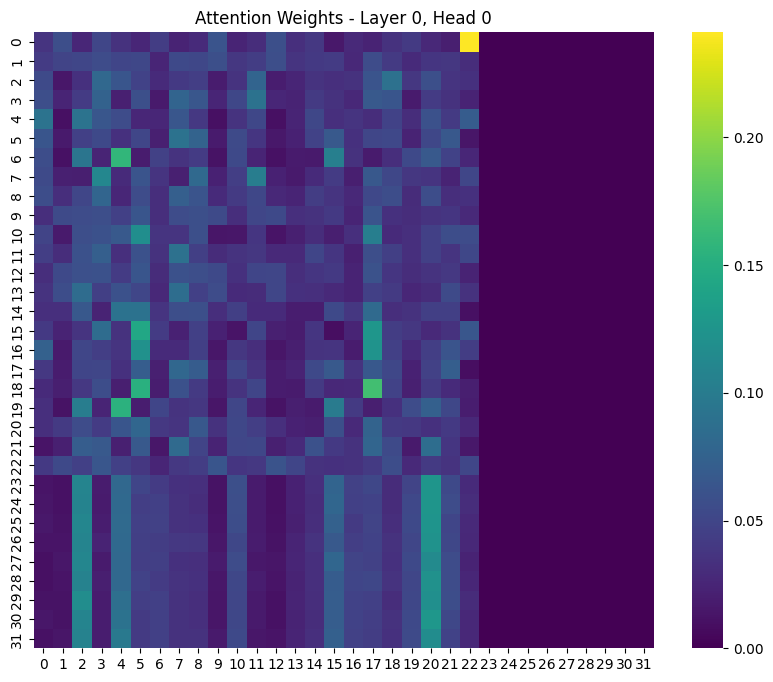

In [36]:
layer = 0  # First layer
head = 0   # First attention head
attention_weights = attentions[layer][0, head].cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights, annot=False, cmap='viridis')
plt.title(f"Attention Weights - Layer {layer}, Head {head}")
plt.show()